# Homework 1

## Instructions

First, ensure you have cloned the [course repository](https://github.com/lydiaYchen/DDL25Spring).

Then, open the [interactive notebook version](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/homework-1.ipynb) of this homework from your local copy.

For part A, fill in the code and answers within the notebook and save your changes.

For part B, create and archive the necessary Python/shell scripts together.

Finally, upload the notebook and the archive to the assignment in ILIAS.

## Part A (12 points)

### Note

When not otherwise specified, use the following parameter values in experiment runs:
- `nr_clients` (N): 100
- `lr`: 0.01
- `client_fraction` (C): 0.1
- `nr_local_epochs` (E): 1
- `batch_size` (B): 100
- `nr_rounds`: 10
- `iid`: True

For all exercises, pass `seed = 10` to calls for splitting data, server initialization, or plotting.

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tutorial_1a.hfl_complete import *

n = 100
lr = 0.01
c = 0.1
e = 1
b = 100
nr_rounds = 10
iid = True
seed = 10

### Exercise A1: FedSGD with weights (3 points)

#### Question

_(2 points)_ Implement a version of FedSGD that uses weights in its updates, like FedAvg, instead of the gradients from the version of the tutorials. The two FedSGD versions should have the same test accuracy after each round (with a tolerance of at most 0.02%). To show this, compare their output for the following two scenarios over *5 rounds*:
- `lr = 0.01, client_subsets = split(100, True, ...), client_fraction = 0.5`
- `lr = 0.1, client_subsets = split(50, False, ...), client_fraction = 0.2`

*Tip:* You can use the existing FedAvg implementation to minimize the amount of code writing required.

**_(1 point)_ Explain in which cases (about the different parameters for decentralized learning) the two are equivalent.**

#### Answer
*The FedAvg and FedSGD can achieve equivalent performance under specific conditions by adjusting certain parameters. The main difference between these two models is their update strategies. FedSGD applies a single gradient step after each round, where each client computes gradients based on their local data and sends the gradient updates to the server. FedAvg typically performs multiple local gradient updates on its weights before sending the updated weights to the server, where the model weights are averaged.*

*To make FedAvg perform like FedSGD, we need to set the number of local rounds (nr_local_rounds) to 1, so that each client only performs one local update per round. This mimics the single gradient step used in FedSGD. In addition, we need to performe this update on all the local data, meaning that the batch size should be set to the size of the client's local data set. This makes sure that each local update in FedAvg is applied in the same way as a gradient step on the full local data set in FedSGD. With these adjustments, FedAvg will behave the same way as FedSGD.*

In [12]:
client_subsets_1 = split(100, True, seed)
server_fed_sgd_weight_1 = FedAvgServer(lr=0.01, batch_size=len(client_subsets_1[0]), client_subsets=client_subsets_1, client_fraction=0.5, nr_local_epochs=1, seed=seed)
result_fed_sgd_weight_1 = server_fed_sgd_weight_1.run(nr_rounds=5)

server_fed_sgd_1 = FedSgdGradientServer(lr=0.01, client_subsets=client_subsets_1, client_fraction=0.5, seed=seed)
result_fed_sgd_1 = server_fed_sgd_1.run(nr_rounds=5)

print("Scenario 1: lr=0.01, client_subsets=split(100, True, seed), client_fraction=0.5")
print("FedSGDWeight results: ", result_fed_sgd_weight_1.test_accuracy)
print("FedSG results: ", result_fed_sgd_1.test_accuracy)

Scenario 1: lr=0.01, client_subsets=split(100, True, seed), client_fraction=0.5
FedSGDWeight results:  [8.84, 13.48, 18.55, 23.08, 27.53]
FedSG results:  [8.84, 13.48, 18.55, 23.08, 27.53]


In [14]:
client_subsets_2 = split(50, False, seed)
server_fed_sgd_weight_2 = FedAvgServer(lr=0.1, batch_size=len(client_subsets_2[0]), client_subsets=client_subsets_2, client_fraction=0.2, nr_local_epochs=1, seed=seed)
result_fed_sgd__weight_2 = server_fed_sgd_weight_2.run(nr_rounds=5)

server_fed_sgd_2 = FedSgdGradientServer(lr=0.1, client_subsets=client_subsets_2, client_fraction=0.2, seed=seed)
result_fed_sgd_2 = server_fed_sgd_2.run(nr_rounds=5)

print("Scenario 2: lr=0.1, client_subsets=split(50, False, seed), client_fraction=0.2")
print("FedSGDWeight results: ", result_fed_sgd__weight_2.test_accuracy)
print("FedSGD results: ", result_fed_sgd_2.test_accuracy)

Scenario 2: lr=0.1, client_subsets=split(50, False, seed), client_fraction=0.2
FedSGDWeight results:  [15.95, 23.36, 13.65, 24.67, 35.7]
FedSGD results:  [15.95, 23.36, 13.65, 24.67, 35.7]


### Exercise A2: Client number & fraction (4 points)

In [ ]:
def run_experiment(fed_method, client_subsets, client_fraction):
    if fed_method == "FedSGD":
        server = FedSgdGradientServer(lr, client_subsets, client_fraction, seed)
    elif fed_method == "FedAvg":
        server = FedAvgServer(lr, b, client_subsets, client_fraction, e, seed)

    result = server.run(nr_rounds)
    return result.message_count, result.test_accuracy

def results_tables(client_numbers, fractions):
    
    results_table = []

    # first table: varying client number for 0.1 clients used in every round
    for N in client_numbers:
        client_subsets = split(N, True, seed) 
        
        for method in ["FedSGD", "FedAvg"]:
            message_count, test_accuracy = run_experiment(method, client_subsets, c)
            results_table.append({
                "Algorithm": method,
                "N": N,
                "C": c,
                "Message count": sum(message_count),
                "Test accuracy": test_accuracy[-1]
            })

    # second table: varying fraction of clients in every round for 100 clients
    for C in fractions:
        client_subsets = split(n, True, seed)
        
        for method in ["FedSGD", "FedAvg"]:
            message_count, test_accuracy = run_experiment(method, client_subsets, C)
            
            results_table.append({
                "Algorithm": method,
                "N": n,
                "C": C,
                "Message count": sum(message_count),
                "Test accuracy": test_accuracy[-1]
            })
    return results_table

In [6]:
# run exepriments
client_numbers = [10, 50, 100]
fractions = [0.01, 0.1, 0.2]
results = results_tables(client_numbers, fractions)
df = pd.DataFrame(results)
print(df)

   Algorithm    N     C  Message count  Test accuracy
0     FedSGD   10  0.10            110          43.34
1     FedAvg   10  0.10            110          93.27
2     FedSGD   50  0.10            550          43.74
3     FedAvg   50  0.10            550          87.70
4     FedSGD  100  0.10           1100          43.41
5     FedAvg  100  0.10           1100          81.62
6     FedSGD  100  0.01            110          40.61
7     FedAvg  100  0.01            110          74.13
8     FedSGD  100  0.10           1100          43.41
9     FedAvg  100  0.10           1100          81.62
10    FedSGD  100  0.20           2200          42.77
11    FedAvg  100  0.20           2200          81.72


#### Question

**_(2 points)_ Run the necessary experiments to fill in the following table showing the final message count and test accuracy of FedSGD and FedAvg for different total client numbers:**

| Algorithm | N   | C   | Message count | Test accuracy |
| --------- | --- | --- | ------------- | ------------- |
| FedSGD    | 10  | 0.1 |     110       |     43.34     |
| FedAvg    | 10  | 0.1 |     110       |     93.27     |
| FedSGD    | 50  | 0.1 |     550       |     43.74     |
| FedAvg    | 50  | 0.1 |     550       |     87.70     |
| FedSGD    | 100 | 0.1 |    1100       |     43.41     |
| FedAvg    | 100 | 0.1 |    1100       |     81.62     |

**Is the relationship between the metrics and client numbers monotonous?**

#### Answer
*The relatonship between the number of clients and the message count is monotonically increasing for both FedSGD and FedAvg identically. As the number of clients increases, the message count also increases from 110 for 10 clients up to 1100 for 100 clients. This happens because the more clients are involved, the more updates are send from the clients to the server, resulting in more messages being exchanged.*

*Looking at the test accuracy, there is a monotonically decreasing relationship visible for the FedAvg. It starts with an accuracy of 93.27% for 10 clients, and drops down to 81.62% for 100 clients. This could be because the more clients are involved, the more generalisable the overal model becomes, which could impact the overall accuracy negatively. This is not noticable in the FedSGD model. Here, the accuracy remains relatively constant at around 43% across different client numbers. This could be because the model performs one gradient step per communication, which could make it less sensitive to the number of clients involved.*

#### Question

**_(2 points)_ Run the experiments to fill in the table when varying the fraction of clients used in every round:**

| Algorithm | N   | C    | Message count | Test accuracy |
| --------- | --- | ---- | ------------- | ------------- |
| FedSGD    | 100 | 0.01 |     110       |    40.61      |
| FedAvg    | 100 | 0.01 |     110       |    74.13      |
| FedSGD    | 100 | 0.1  |    1100       |    43.41      |
| FedAvg    | 100 | 0.1  |    1100       |    81.62      |
| FedSGD    | 100 | 0.2  |    2200       |    42.77      |
| FedAvg    | 100 | 0.2  |    2200       |    81.72      |

**How does the observed pattern differ?**

#### Answer
*In this table, we see a similar pattern for the message count as before. The message count increases consistently with the fraction of clients being used for both the FedAvg and FedSGD. This makes sense, because if we have 100 clients and only use a fraction of 0.01 at a time, this is equivalent to having 10 clients and using a fraction of 0.1 clients. Therefore, we again have a monotonically increasing relationship between the fraction of clients and the message count.*

*Regarding the test accuracy, a similar trend is visible for the FedSGD, where the test accuracy is relatively constant across different client fractions. For FedAVg, the opposite behaviour is visible as displayed in the previous table. As the fraction of clients used in each round increases, the test accuracy improves monotonically.*

### Exercise A3: Local epoch count & (non-)IID data (5 points)

### Experiment: 1

**_(1 point)_ Create a line plot of the accuracy after each round for the following algorithm variants:**

- FedSGD
- FedAvg (E=1)
- FedAvg (E=2)
- FedAvg (E=4)

In [2]:
# FedSGD
sample_split = split(n, True, seed)
fedsgd_server = FedSgdGradientServer(lr, sample_split, c, seed)
fedsgd_results= fedsgd_server.run(nr_rounds)
fedsgd_df = fedsgd_results.as_df()
fedsgd_df['E'] = 0

In [ ]:
# FedAvg
local_epochs = [1,2,4]
fedavg_results = []
for E in local_epochs:
    fedavg_server = FedAvgServer(lr, n, sample_split, c, E, seed)
    fedavg_result = fedavg_server.run(nr_rounds)
    fedavg_df = fedavg_result.as_df()
    fedavg_df['E'] = E
    fedavg_results.append(fedavg_df)
    

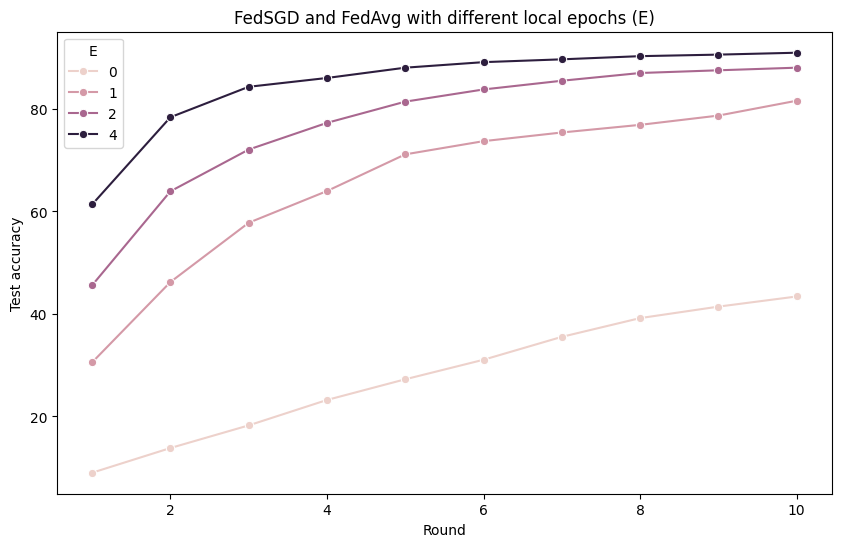

In [ ]:
fedavg_df_plot = pd.concat([fedsgd_df, fedavg_results[0], fedavg_results[1], fedavg_results[2]], ignore_index=True)

plt.figure(figsize=(10, 6))

sns.lineplot(data=fedavg_df_plot, x='Round', y='Test accuracy', hue='E', marker='o')

plt.title('FedSGD and FedAvg with different local epochs (E)')
plt.xlabel('Round')
plt.ylabel('Test accuracy')
plt.show()

#### Question

**How does FedAvg compare to FedSGD? What is the effect of increasing the work clients perform locally for each update in FedAvg?**

#### Anwser

*The plot above displays the performance of FedSGD (E=0) and FedAvg (E=1,2,4) over multiple rounds using different numbers of local rounds. It is clearly noticable that FedAvg outperformes FedSGD over 10 rounds, regardless of how many local epochs are applied to it. After the 10th round, FedSGD achieves a similar test accuracy to FedAvg with 2 local epochs after one round. The difference in performance is likely due to the update strategies of the models. While FedSGD performs one gradient step per round, it takes much more time to convergence but results in a more stable learning process. Whereas FedAvg learns fast by updating its weights locally, but may be less stable.*

*When we look at the impact of increasing the number of local epochs (E), we see that FedAvg's performance improves in terms of test accuracy over 10 rounds. The paraemeter E controls how many updates clients perform before they send their weights to the server for aggregation. The more local updates clients make, the better their performance. This is likely due to applying multiple local epochs allows clients to improve their local models before synchronizing with the global model, leading to a more effective learning process.*

### Experiment: 2
_(2 points)_ Make one line plot of FedSGD and FedAvg under an IID and non-IID split for 15 rounds (leaving all other parameter values as they previously mentioned default).

In [48]:
sample_split = split(n, True, seed)
fedavg_server_iidTrue_nr15 = FedAvgServer(lr, n, sample_split, c, e, seed)
result_fedavg_iidTrue_nr15 = fedavg_server_iidTrue_nr15.run(15)
fedavg_iidTrue_nr15_df = result_fedavg_iidTrue_nr15.as_df()

In [49]:
sample_split = split(n, False, seed)
fedavg_server_iidFalse_nr15 = FedAvgServer(lr, n, sample_split, c, e, seed)
result_fedavg_iidFalse_nr15 = fedavg_server_iidFalse_nr15.run(15)
fedavg_iidFalse_nr15_df = result_fedavg_iidFalse_nr15.as_df()

In [50]:
sample_split = split(n, True, seed)
fedsgd_server_iidTrue_nr15 = FedSgdGradientServer(lr, sample_split, c, seed)
result_fedsgd_iidTrue_nr15 = fedsgd_server_iidTrue_nr15.run(15)
fedsgd_iidTrue_nr15_df = result_fedsgd_iidTrue_nr15.as_df()

In [51]:
sample_split = split(n, False, seed)
fedavg_server_iidFalse_nr15 = FedSgdGradientServer(lr, sample_split, c, seed)
result_fedsgd_iidFalse_nr15 = fedavg_server_iidFalse_nr15.run(15)
fedsgd_iidFalse_nr15_df = result_fedsgd_iidFalse_nr15.as_df()

In [52]:
fedavg_iidTrue_nr15_df_plot = fedavg_iidTrue_nr15_df.copy()
fedavg_iidTrue_nr15_df_plot['IID'] = True

fedavg_iidFalse_nr15_df_plot = fedavg_iidFalse_nr15_df.copy()
fedavg_iidFalse_nr15_df_plot['IID'] = False

fedsgd_iidTrue_nr15_df_plot = fedsgd_iidTrue_nr15_df.copy()
fedsgd_iidTrue_nr15_df_plot['IID'] = True

fedsgd_iidFalse_nr15_df_plot = fedsgd_iidFalse_nr15_df.copy()
fedsgd_iidFalse_nr15_df_plot['IID'] = False

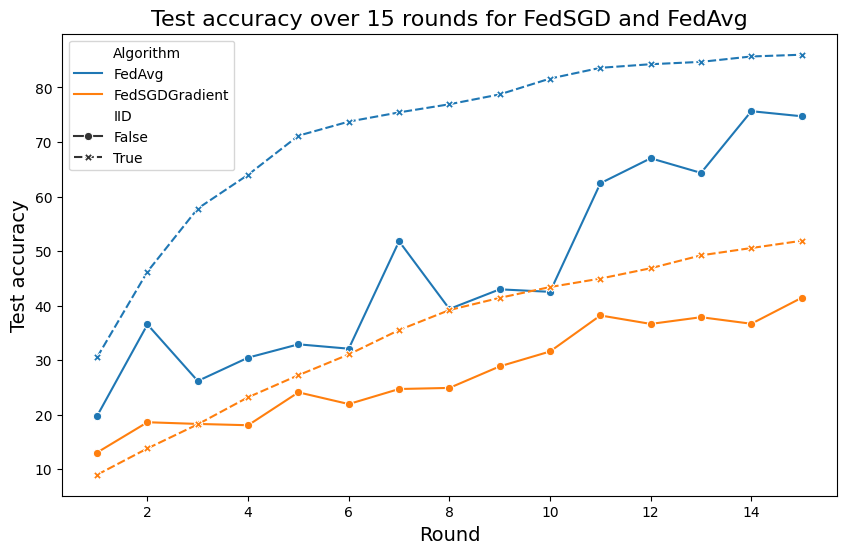

In [53]:
combined_fed_iid_nr15_df = pd.concat([fedavg_iidTrue_nr15_df_plot, fedavg_iidFalse_nr15_df_plot, fedsgd_iidTrue_nr15_df_plot, fedsgd_iidFalse_nr15_df_plot], ignore_index=True)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_fed_iid_nr15_df, x='Round', y='Test accuracy', hue='Algorithm', style='IID', markers=True)

plt.title('Test accuracy over 15 rounds for FedSGD and FedAvg', fontsize=16)
plt.xlabel('Round', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.show()

#### Question
**How does the non-IID setting affect the accuracy achieved by the two algorithms? What is the difference in terms of the smoothness of learning?**

#### Anwser

*The graph above shows the performance of both the FedAvg and FedSGD models in two settings: IID (True) and non-IID (False), over 15 rounds of training. We can see that FedAvg outperforms FedSGD regarding its accuracy, both when IID is true and false, within the short training period of 15 rounds. When the IID setting is False, we can see a clear drop in test accuracy across the 15 rounds for both models. Additionally, we can observe a much higher fluctuation in their accuracy. This is especially true for FedAvg, where the degree of fluctuation is much higher than what we can observe with FedSGG. FedAvg also displays a bigger gap in accuracy betwen it's IID and non-IID performance.*

*These results suggests that non-IID distributions lead to more variability in the learning process for both models, which we can observe in the fluctuation in accuracy. The FedSGD model is somewhat more robust to this than FedAvg, but FedAvg still learns faster and achieves higher accuracy overall. Overall, IID affects both models performance and consistency.*

### Run experiment: 3
_(2 points)_ Make another plot for only non-IID splits, including the FedSGD and FedAvg configs from before, and add a version for each with a learning rate of 0.001 and client fraction of 0.5. 

In [54]:
sample_split = split(n, False, seed)
fedavg_server_iidFalse_nr15_c_lr = FedAvgServer(0.001, n, sample_split, 0.5, e, seed)
result_fedavg_iidFalse_nr15_c_lr = fedavg_server_iidFalse_nr15_c_lr.run(15)
fedavg_iidFalse_nr15_c_lr_df = result_fedavg_iidFalse_nr15_c_lr.as_df()

In [55]:
sample_split = split(n, False, seed)
fedavg_server_iidFalse_nr15_c_lr = FedSgdGradientServer(0.001, sample_split, 0.5, seed)
result_fedsgd_iidFalse_nr15_c_lr = fedavg_server_iidFalse_nr15_c_lr.run(15)
fedsgd_iidFalse_nr15_c_lr_df = result_fedsgd_iidFalse_nr15_c_lr.as_df()

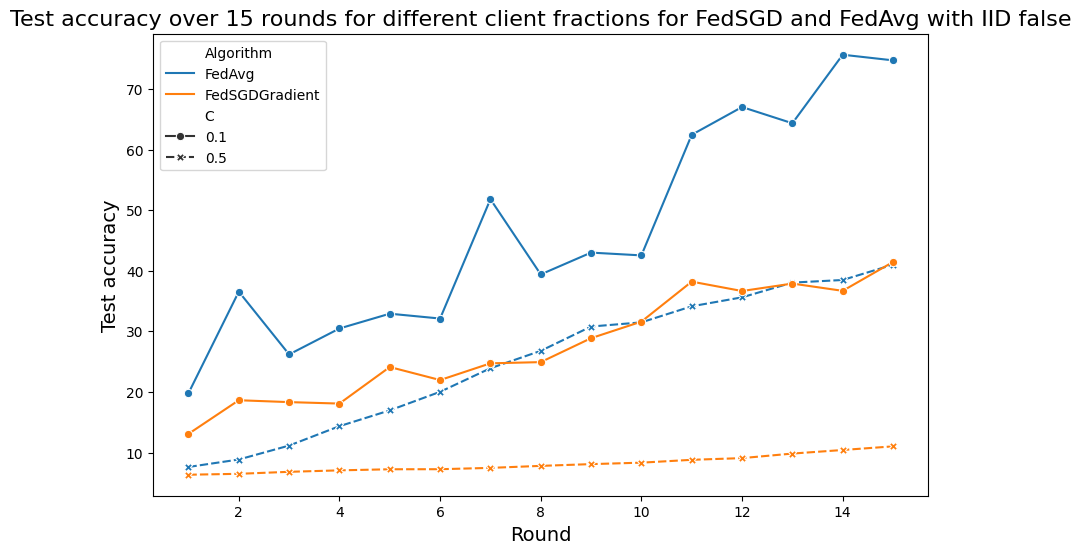

In [56]:
combined_fed_iid_nr15_c_df = pd.concat([fedavg_iidFalse_nr15_df, fedavg_iidFalse_nr15_c_lr_df, fedsgd_iidFalse_nr15_df, fedsgd_iidFalse_nr15_c_lr_df], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_fed_iid_nr15_c_df, x='Round', y='Test accuracy', hue='Algorithm', style='C', markers=True)

plt.title('Test accuracy over 15 rounds for different client fractions for FedSGD and FedAvg with IID false', fontsize=16)
plt.xlabel('Round', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.show()

#### Question
**How does the stability of the new variants compare to the old ones? Why do the changes in parameters have the observed effect?**

#### Anwser

*Decreasing the learning rate and increasing the client fraction makes the FedAvg and FedSGD perform much more stable when applying non-IID. Adapting these parameters help decrease the high fluctuation of the test accuracy. But this also comes with a trade-off. The overall accuracy for both models is much lower than before. Overall, stability improves, but the trade-off is a decrease in accuracy.*

*By choosing a smaller learning rate, we prevent large, instable updates. This is visible in the graph. We can still observe fluctuations over each round, but they are less pronounced. Increasing the client fraction means more clients update the global model, adding diversity and reducing variance, which also has an impact on the fluctuation. But these changes slow down the convergence of each model, which cause a drop in test accuracy. This is especially noticable in the FedSGD model, probably because small gradient steps are more affected by the smaller update steps than faster local weight updates in FedAvg.*

## Part B (12 points)

### Exercise B1: Microbatch Pipeline Model Parallelism (7 points)

Implement pipeline parallelism with microbatches, as discussed during the lab.

As with the other data/model parallelism examples, you will need a Python script for the nodes and a shell script to orchestrate execution.

Be aware of the possibility of deadlocks: due to how `good` operates, it is possible to deadlock by having device 1 send $B_2$ to device 2 in the forward pass, and simultaneously, device 2 send $B_1$ in the backward pass.
Since both operations will await a corresponding receive the training will stop indefinitely.

Use `isend` & `irecv`, the asynchronous (non-blocking) versions of `send` & `recv` in `torch.distributed`.
Add comments or text explaining how you expect your implementation to work and test that it runs for the same number of steps and model architecture as in class.

Note that `torch.distributed`'s implementation of `gloo` does not currently support properly asynchronous communication even when using the corresponding primitives.
Thus, you will not see the same improvements in speed as with a backend like `nccl`.

You may also take advantage of the fact that `torch` gradients naturally accumulate if zeroed out.
Also, scaling the loss by a constant is equivalent to scaling the resulting gradients by the same constant.

### Exercise B2: Joint Data & Model Parallelism (5 points)

Implement a training setup that uses data and model parallelism together.

Create 2 pipelines of 3 stages running sequentially, where each stage works with 3 sequential micro-batches.

Once again, add comments or text explaining your implementation and test it on the setting that mimics those from the class.

You can use groups from `torch.distributed` to handle operations that require interaction between a subset of more than two but less than all workers.